# Multiple Rectangles Detection

## Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math
%matplotlib inline

## Data Generation

In [58]:
num_imgs = 60000

img_size = 10
min_rect_size = 2
max_rect_size = 5
num_objects = 3

bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size))

for i_img in range(num_imgs):
    for i_object in range(num_objects):
        width, height = np.random.randint(min_rect_size, max_rect_size, size = 2)
        x = np.random.randint(0, img_size - width)
        y = np.random.randint(0, img_size - height)
        imgs[i_img, x:x + width, y:y + height] = 1.
        bboxes[i_img, i_object] = [x, y, width, height]

'''
    # Prevent overlap between rectangles.
    # Makes results (i.e. mean IOU) slightly worse; probably because the shapes are smaller
    # (i.e. they are harder to recognize and capture within a bbox)
    # and further apart (i.e. the algorithm can't set all bboxes to the same location to get a good IOU).
    i_object = 0
    while i_object < num_objects:
        width, height = np.random.randint(min_rect_size, max_rect_size, size = 2)
        x = np.random.randint(0, img_size - width)
        y = np.random.randint(0, img_size - height)
        overlap = False
        print('Creating object', i_object, ' - checking', len(bboxes[i_img, :i_object]), 'bboxes for overlap', )
        for bbox in bboxes[i_img, :i_object]:  # TODO: Check if this includes all bboxes.
            overlap = bool(IOU(bbox, [x - 1, y - 1, width + 2, height + 2]))  # at least one free field between objects
            if overlap:
                print('--> Found overlap')
                break
            if not overlap:
                imgs[i_img, x:x + width, y:y + height] = 1.
                bboxes[i_img, i_object] = [x, y, width, height]
                i_object += 1
                print('--> Found no overlap')
'''

imgs.shape, bboxes.shape

((60000, 10, 10), (60000, 3, 4))

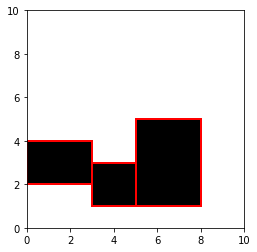

In [59]:
i = 0
plt.imshow(imgs[i].T, cmap = 'Greys', interpolation = 'none', origin = 'lower', extent = [0, img_size, 0, img_size])
for bbox in bboxes[i]:
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], lw = 2, ec = 'r', fc = 'none'))

## Preprocessing

In [60]:
# Reshape and normalize the data to mean 0 and std 1.
X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)
X.shape, np.mean(X), np.std(X)

((60000, 100), 2.3711995330207477e-17, 0.9999999999999998)

In [61]:
y = bboxes.reshape(num_imgs, -1) / img_size
y.shape

(60000, 12)

## Train Test Split

In [62]:
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

## CNN Model

In [63]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD
from keras.models import load_model
model = Sequential([
        Dense(256, input_dim = X.shape[-1]), 
        Activation('relu'), 
        Dropout(0.6), 
        Dense(y.shape[-1])
    ])
model.compile(loss = 'mse', optimizer = 'adam')
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 256)               25856     
_________________________________________________________________
activation_6 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 12)                3084      
Total params: 28,940
Trainable params: 28,940
Non-trainable params: 0
_________________________________________________________________


## IoU Calculating Function

In [64]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]  # TODO: Check if its more performant if tensor elements are accessed directly below.
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

## Distance Calculating function

In [65]:
def distance(bbox1, bbox2):
    return np.sqrt(np.sum(np.square(bbox1[:2] - bbox2[:2])))

## Training

In [66]:
from itertools import permutations
num_epochs = 50
fact = math.factorial(num_objects)

flipped_train_y = np.array(train_y)
flipped = np.zeros((len(flipped_train_y), num_epochs))
ious_epochs = np.zeros((len(flipped_train_y), num_epochs))
dists_epochs = np.zeros((len(flipped_train_y), num_epochs))
mses_epochs = np.zeros((len(flipped_train_y), num_epochs))

for epoch in range(num_epochs):
    print('Epoch ', epoch)
    model.fit(train_X, flipped_train_y, epochs = 1, validation_data = (test_X, test_y), verbose = 1, 
              callbacks = [ModelCheckpoint('Multiple_Rectangles_model.h5', 
                                           monitor = 'val_loss',
                                           save_best_only = True)])
    pred_y = model.predict(train_X)
    
    for i, (pred_bboxes, exp_bboxes) in enumerate(zip(pred_y, flipped_train_y)):
        
        pred_bboxes = pred_bboxes.reshape(num_objects, -1)
        exp_bboxes = exp_bboxes.reshape(num_objects, -1)
        
        p_exp_bboxes = list(permutations(exp_bboxes))
        ious = np.zeros((fact, num_objects))
        dists = np.zeros((fact, num_objects))
        mses = np.zeros((fact, num_objects))
        p_ious = np.zeros(fact)
        p_mses = np.zeros(fact)
        p_dists = np.zeros(fact)
        
        for j, exp_bboxes in enumerate(p_exp_bboxes):
            exp_bboxes = list(exp_bboxes) 
            for k in range(num_objects):
                ious[j, k] = IOU(exp_bboxes[k], pred_bboxes[k])
                dists[j, k] = distance(exp_bboxes[k], pred_bboxes[k])
                mses[j, k] = np.mean(np.square(exp_bboxes[k] - pred_bboxes[k]))
            p_ious[j] = sum(ious[j, :])
            p_dists[j] = sum(dists[j, :])
            p_mses[j] = sum(mses[j, :])
            
        keymax = p_ious.argmax()
        ious_epochs[i, epoch] += p_ious[keymax] / num_objects
        dists_epochs[i, epoch] += p_dists[keymax] / num_objects
        mses_epochs[i, epoch] += p_mses[keymax] / num_objects
        
        flipped_train_y[i] = np.array(p_exp_bboxes[keymax]).flatten()
        if keymax != 0:
            flipped[i, epoch] = 1.
    
    print('Flipped {} % of all elements'.format(np.mean(flipped[:, epoch]) * 100.))
    print('Mean IOU: {}'.format(np.mean(ious_epochs[:, epoch])))
    print('Mean dist: {}'.format(np.mean(dists_epochs[:, epoch])))
    print('Mean mse: {}'.format(np.mean(mses_epochs[:, epoch])))

Epoch  0
1500/1500 [==============================] - 1s 847us/step - loss: 0.0476 - val_loss: 0.0190
Flipped 81.05 % of all elements
Mean IOU: 0.18242600593970534
Mean dist: 0.22433210032522805
Mean mse: 0.018320519374899726
Epoch  1
1500/1500 [==============================] - 1s 839us/step - loss: 0.0183 - val_loss: 0.0201
Flipped 49.635416666666664 % of all elements
Mean IOU: 0.2614987627304945
Mean dist: 0.18502563644922254
Mean mse: 0.014167377137896666
Epoch  2
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0147 - val_loss: 0.0229
Flipped 25.183333333333337 % of all elements
Mean IOU: 0.3320116756362739
Mean dist: 0.15241281599909387
Mean mse: 0.010992454538267353
Epoch  3
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0125 - val_loss: 0.0243
Flipped 16.995833333333334 % of all elements
Mean IOU: 0.3792091219589422
Mean dist: 0.13355143007257564
Mean mse: 0.00925091417693392
Epoch  4
1500/1500 [==============================] - 1s 946us/st

1500/1500 [==============================] - 1s 879us/step - loss: 0.0086 - val_loss: 0.0265
Flipped 6.260416666666667 % of all elements
Mean IOU: 0.46542896371967474
Mean dist: 0.09851977601226014
Mean mse: 0.006217210376646372
Epoch  36
1500/1500 [==============================] - 1s 860us/step - loss: 0.0086 - val_loss: 0.0268
Flipped 7.735416666666667 % of all elements
Mean IOU: 0.46349573397350113
Mean dist: 0.1001622520559394
Mean mse: 0.006321439746412221
Epoch  37
1500/1500 [==============================] - 1s 856us/step - loss: 0.0086 - val_loss: 0.0272
Flipped 7.6395833333333325 % of all elements
Mean IOU: 0.4798225959429692
Mean dist: 0.09428811371773986
Mean mse: 0.005991302641156216
Epoch  38
1500/1500 [==============================] - 1s 889us/step - loss: 0.0086 - val_loss: 0.0264
Flipped 7.139583333333334 % of all elements
Mean IOU: 0.45771257061432996
Mean dist: 0.10090024970717658
Mean mse: 0.006319119043228313
Epoch  39
1500/1500 [==============================] - 

## Flipping Track

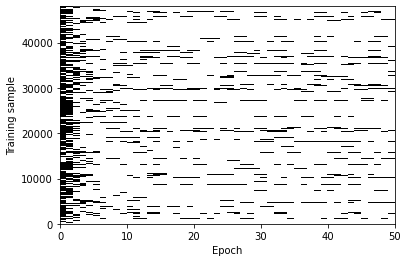

In [67]:
# Show flippings for a few training samples.
plt.pcolormesh(flipped[:, :], cmap = 'Greys')
plt.xlabel('Epoch')
plt.ylabel('Training sample')
plt.savefig('multiple-rectangles_flips.png', dpi = 100)
plt.show()

## Metrics Track

(0.0, 0.8)

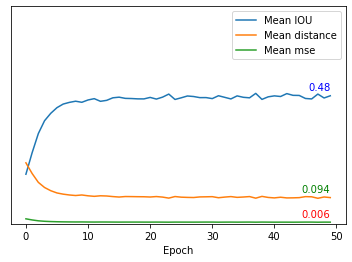

In [69]:
# Plot metrics on the training data.
mean_ious_epoch = np.mean(ious_epochs, axis = 0)
mean_dists_epoch = np.mean(dists_epochs, axis = 0)
mean_mses_epoch = np.mean(mses_epochs, axis = 0)
plt.plot(mean_ious_epoch, label = 'Mean IOU')  # between predicted and assigned true bboxes
plt.plot(mean_dists_epoch, label = 'Mean distance')  # relative to image size
plt.plot(mean_mses_epoch, label = 'Mean mse')
plt.annotate(np.round(np.max(mean_ious_epoch), 3), (len(mean_ious_epoch) - 1, mean_ious_epoch[-1] + 0.02), horizontalalignment = 'right', color = 'b')
plt.annotate(np.round(np.min(mean_dists_epoch), 3), (len(mean_dists_epoch) - 1, mean_dists_epoch[-1] + 0.02), horizontalalignment = 'right', color = 'g')
plt.annotate(np.round(np.min(mean_mses_epoch), 3), (len(mean_mses_epoch) - 1, mean_mses_epoch[-1] + 0.02), horizontalalignment = 'right', color = 'r')

plt.xlabel('Epoch')
# Hide y tick
ax = plt.gca()
ax.axes.yaxis.set_visible(False)

plt.legend()
plt.ylim(0, 0.8)

## Denormalize Data

In [70]:
pred_y = model.predict(test_X)
pred_bboxes = pred_y * img_size
pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), num_objects, -1)
pred_bboxes.shape

(12000, 3, 4)

## Visualize Results

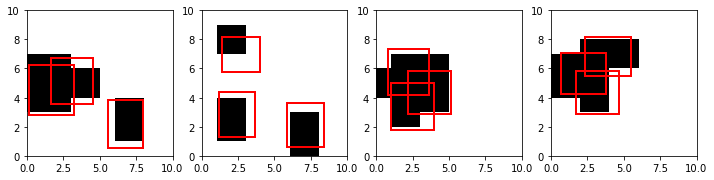

In [71]:
plt.figure(figsize = (12, 3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_X))
    plt.imshow(test_imgs[i].T, cmap = 'Greys', interpolation = 'none', origin = 'lower', extent = [0, img_size, 0, img_size])
    for pred_bbox, exp_bbox in zip(pred_bboxes[i], test_bboxes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], lw = 2, ec = 'r', fc = 'none'))
        # TODO: Calculate max IOU with all expected bounding boxes.
#         plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.4), color='r')

## Overall Assessment

In [74]:
from keras.models import load_model
model_test = load_model('Multiple_Rectangles_model.h5')
pred_y = model_test.predict(test_X)
pred_bboxes = pred_y * img_size
pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), num_objects, -1)
summed_IOU = 0.
for pred_bbox, test_bbox in zip(pred_bboxes.reshape(-1, 4), test_bboxes.reshape(-1, 4)):
    summed_IOU += IOU(pred_bbox, test_bbox)
mean_IOU = summed_IOU / len(pred_bboxes)
print('IoU:', mean_IOU)

IoU: 0.6675773082607528
